# Introduction



Data can be accessed from this google drive link. The "play log" contains the records of users active session. There are 9 mini games inside the app "Lengbear", an social casino games made and publish exclusively for Cambodia. The transactions log is the records of user in app purchase.

play log file url: https://drive.google.com/file/d/10urw6q7ahacPIYImSeSHCRhrGb5eCZ60/view?usp=sharing

transaction url: https://drive.google.com/file/d/1zVAIiW5jjFwbcFOAr6ey4r4FdRaDVzoB/view?usp=sharing

Lengbear game url: https://play.google.com/store/apps/details?id=leng.bear.free.cm&hl=en_CA


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

## Transaction Log

The transaction log is from 2020-03-01 to 2020-05-13, consists 342,544 unique entries. I will first examines the data and see what insights can be gained from this data. 

In [2]:
# Load the transactions log data
transactions_df=pd.read_csv('data/transactions.csv', index_col=0, infer_datetime_format=True)
transactions_df.head()

,UserID,Amount,Chips,Date,Channel
0,4403840,0.5,600000,2020-03-04 00:00:09.270,DCB_Smart_Axiata
1,4209368,1.0,2000000,2020-03-04 00:01:07.777,Wing
2,4627993,0.2,200000,2020-03-04 00:01:15.257,DCB_Smart_Axiata
3,4689823,0.2,200000,2020-03-04 00:01:53.540,DCB_Smart_Axiata
4,5209800,0.2,200000,2020-03-04 00:02:11.197,DCB_Smart_Axiata


In [3]:
# Check if there is any missing values
transactions_df.isna().sum()

UserID     0
Amount     0
Chips      0
Date       0
Channel    0
dtype: int64

In [4]:
# Inspect the columns and datatype
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342544 entries, 0 to 342543
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   UserID   342544 non-null  int64  
 1   Amount   342544 non-null  float64
 2   Chips    342544 non-null  int64  
 3   Date     342544 non-null  object 
 4   Channel  342544 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 15.7+ MB


In [5]:
# Slice away the purchasing time for date in transaction data
transactions_df['Date']=pd.to_datetime(transactions_df['Date'].str[:10])
transactions_df.head()

,UserID,Amount,Chips,Date,Channel
0,4403840,0.5,600000,2020-03-04,DCB_Smart_Axiata
1,4209368,1.0,2000000,2020-03-04,Wing
2,4627993,0.2,200000,2020-03-04,DCB_Smart_Axiata
3,4689823,0.2,200000,2020-03-04,DCB_Smart_Axiata
4,5209800,0.2,200000,2020-03-04,DCB_Smart_Axiata


### Overview of sales trend

In general, sales have been slowing down since people got into lockdown for Covid-19.

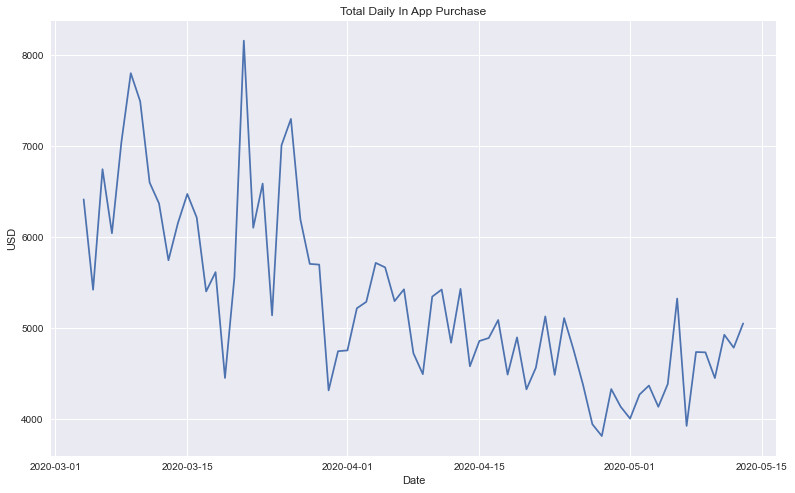

In [6]:
# Calculate sales by day
transactions_df_sum=pd.DataFrame(transactions_df.groupby('Date').sum()['Amount']).reset_index()
transactions_df_sum['Day']=pd.to_datetime(transactions_df_sum['Date']).dt.day_name()

# Visualize sales by day of the period
plt.figure(figsize=(13,8))
sns.lineplot(transactions_df_sum['Date'], transactions_df_sum['Amount'], sizes=(13,8))
plt.ylabel('USD')
plt.title('Total Daily In App Purchase')
plt.savefig('IAP by data.png', dpi=400)
plt.show()

### Sales generated on day of the week

The data on hand shows that in general, Saturday is the time people buys the most. Friday sales are usually lower, possibly because users hang out during Friday night and staying indoor to play game on Saturday. Sunday seems to generate less playing time too as people are prepare for the new working week. 

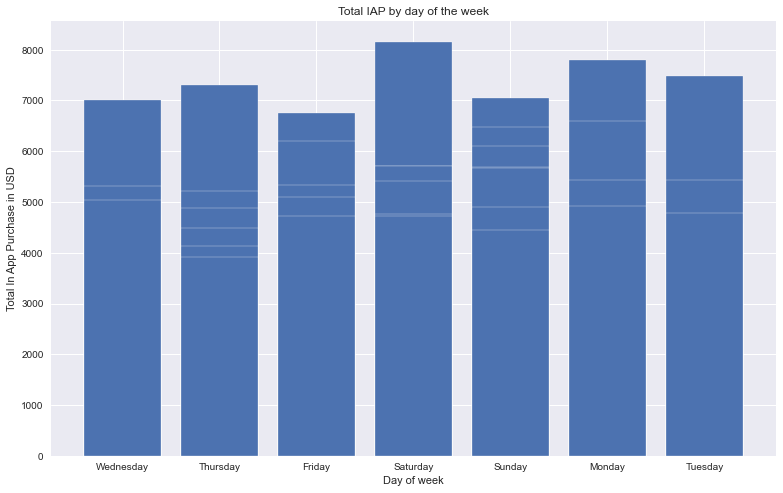

In [7]:
# Visualize sales by day of week 
plt.figure(figsize=(13,8))
plt.bar(transactions_df_sum['Day'], transactions_df_sum['Amount'])
plt.xlabel('Day of week')
plt.ylabel('Total In App Purchase in USD')
plt.title('Total IAP by day of the week')
plt.savefig('Total IAP by day of the week.png', dpi=400)
plt.show()

### Popularity of payment channels

The most popular payment channels that users use to buy in-app items are through the use of direct carrier billing with Smart Telecommunication and the second most popular is Wing (an e-wallet company). While Direct Carrier Billing with Smart is the most popular, the average transaction size is the smallest. This shows that majority of the users use Smart as their mobile service provider. In general, e-wallets such as Wing, Asia, and Pipay has much higher average transaction size. 

In [8]:
# Count the Amount generated by each in app purchase channel and the number of use
transactions_iap_by_channels=transactions_df.groupby('Channel').sum()['Amount'].reset_index()
transactions_iap_by_channels['Use_Count']=transactions_iap_by_channels['Channel'].map(transactions_df['Channel'].value_counts())
transactions_iap_by_channels['Average_Transaction_in_$']=transactions_iap_by_channels['Amount']/transactions_iap_by_channels['Use_Count']
transactions_iap_by_channels=transactions_iap_by_channels.sort_values('Amount', ascending=False).set_index('Channel')
transactions_iap_by_channels

,Amount,Use_Count,Average_Transaction_in_$
Channel,,,
DCB_Smart_Axiata,162931.61,226264,0.720095
Wing,114243.00,35917,3.180750
DCB_Cellcard_Coda,65953.20,70179,0.939785
Wing_Local,25946.59,5712,4.542470
DCB_Metfone_Coda,3277.50,2941,1.114417
Asia,2886.00,1052,2.743346
Pipay,1592.00,478,3.330544
DCB_Unitel,0.23,1,0.230000


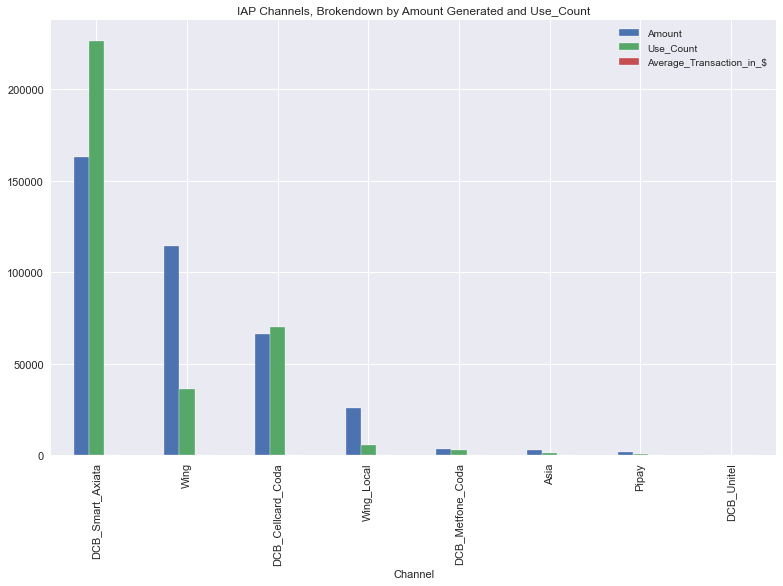

In [9]:
# Plot IAP Channels, brokendown by amount generated and Use_Count
fig=transactions_iap_by_channels.plot(kind='bar', figsize=(13,8), fontsize=11, title='IAP Channels, Brokendown by Amount Generated and Use_Count').get_figure()
fig.savefig('IAP Channels, brokendown by amount generated and Use_Count.pdf', dpi=400)

## Play Log Data

The play log is generated from 2020-05-01 to 2020-05-13. Each line is an online playing session of an unique UserID with an unique GameID and unique Betting Level. There are 1,768,640 rows and 12 columns in the data. 


In [10]:
# Load the play log file and check if there is any missing values
play_log_df=pd.read_csv('data/playlog01-130520.csv', index_col=0)
play_log_df.head()

/Users/Ben/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Sequence,UserID,GameID,Level,WinNo,DrawNo,LostNo,WinAmt,LostAmt,Date,Currency_Type1,Currency_Type2
0,50518638,5894561,9009,1000,0,0,1,0,24964,2020-05-09 00:00:00.000,0,0
1,50518637,6047531,9009,20,2,0,0,515,0,2020-05-09 00:00:00.000,0,0
2,50518636,4972744,9009,100,1,0,3,1748,7800,2020-05-09 00:00:00.000,0,0
3,50518635,5608136,9009,1000,9,0,15,128680,137000,2020-05-09 00:00:00.000,0,0
4,50518634,4725768,9009,100,10,0,34,18272,27100,2020-05-09 00:00:00.000,0,0


In [11]:
# Check missing value
play_log_df.isna().sum()

Sequence          0
UserID            0
GameID            0
Level             0
WinNo             0
DrawNo            0
LostNo            0
WinAmt            0
LostAmt           0
Date              0
Currency_Type1    0
Currency_Type2    0
dtype: int64

In [12]:
# Review play_log data frame
play_log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768640 entries, 0 to 1768639
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Sequence        int64 
 1   UserID          int64 
 2   GameID          int64 
 3   Level           int64 
 4   WinNo           int64 
 5   DrawNo          int64 
 6   LostNo          int64 
 7   WinAmt          int64 
 8   LostAmt         int64 
 9   Date            object
 10  Currency_Type1  int64 
 11  Currency_Type2  int64 
dtypes: int64(11), object(1)
memory usage: 175.4+ MB


In [13]:
# Further reviewing data in each column
play_log_df.describe()

,Sequence,UserID,GameID,Level,WinNo,DrawNo,LostNo,WinAmt,LostAmt,Currency_Type1,Currency_Type2
count,1.768640e+06,1.768640e+06,1.768640e+06,1.768640e+06,1.768640e+06,1768640.0,1.768640e+06,1.768640e+06,1.768640e+06,1768640.0,1768640.0
mean,5.028838e+07,5.173211e+06,8.710541e+03,7.668269e+03,5.716449e+00,0.0,1.188716e+01,5.630973e+05,6.238427e+05,0.0,0.0
std,5.105625e+05,1.269449e+06,1.509552e+03,6.928382e+04,1.421466e+01,0.0,4.580591e+01,9.817862e+06,1.018438e+07,0.0,0.0
min,4.940406e+07,1.230000e+02,1.008000e+03,2.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
25%,4.984622e+07,4.952213e+06,9.002000e+03,1.000000e+02,0.000000e+00,0.0,2.000000e+00,0.000000e+00,1.240000e+03,0.0,0.0
50%,5.028838e+07,5.776227e+06,9.009000e+03,1.000000e+02,2.000000e+00,0.0,4.000000e+00,1.855000e+03,7.000000e+03,0.0,0.0
75%,5.073054e+07,5.972449e+06,9.009000e+03,1.000000e+03,6.000000e+00,0.0,1.000000e+01,2.226425e+04,3.971025e+04,0.0,0.0
max,5.117270e+07,6.104168e+06,9.009000e+03,1.000000e+07,1.383000e+03,0.0,6.482000e+03,2.525479e+09,2.567000e+09,0.0,0.0


In [14]:
# Remove redundant columns namely: Sequence, DrawNo, Currency_Type1, Currency_Type2 since they are all 0 and set the time to regular format
play_log_df.drop(['Sequence', 'DrawNo', 'Currency_Type1', 'Currency_Type2'], axis=1, inplace=True)
play_log_df['Date']=pd.to_datetime(play_log_df['Date'].str[:10])
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date
0,5894561,9009,1000,0,1,0,24964,2020-05-09
1,6047531,9009,20,2,0,515,0,2020-05-09
2,4972744,9009,100,1,3,1748,7800,2020-05-09
3,5608136,9009,1000,9,15,128680,137000,2020-05-09
4,4725768,9009,100,10,34,18272,27100,2020-05-09


In [15]:
# Making the dataframe for GameID and Match_Length in seconds (data provided by game owner)
# Gamename BINH                9001: 80 seconds
# Gamename POKDENG             9002: 80 seconds
# Gamename BAUCUA              9005: 20 seconds
# Gamename SHOW                9004: 80 seconds
# Gamename XOCDIA              9003: 20 seconds
# Gamename SIKU                9006: 80 seconds
# Gamename SLOT_20_LINE        9008: 20 seconds
# Gamename SLOT_100_LINE       1008: 20 seconds
# Gamename TIENLEN_CAM         9009: 120 seconds
Game_Code_Length=pd.DataFrame({'GameID':[9001, 9002, 9005, 9004, 9003, 9006, 9008, 1008, 9009],
                               'Match_Length':[75,75,20,75,20,75,20,20,120]})

In [16]:
# Getting the Match_Length column ready to calculate the active session of user
play_log_df=play_log_df.merge(Game_Code_Length, on='GameID', how='left')
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120
1,6047531,9009,20,2,0,515,0,2020-05-09,120
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120


In [17]:
# Counting the number of games play in each log and get the actual active play time of users in seconds
play_log_df['Games_Played']=play_log_df['WinNo']+play_log_df['LostNo']
play_log_df['Active_Time']=play_log_df['Games_Played']*play_log_df['Match_Length']
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length,Games_Played,Active_Time
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120,1,120
1,6047531,9009,20,2,0,515,0,2020-05-09,120,2,240
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120,4,480
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120,24,2880
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120,44,5280


In [18]:
# Get lists of unique GameID and unique betting_level
gameid=list(play_log_df['GameID'].unique())
betting_level=list(play_log_df['Level'].unique())

# Count number of minigames that user play in each log
for GameID in gameid:
    play_log_df[GameID]=np.where(play_log_df['GameID']==GameID, play_log_df['Games_Played'], 0)

# Count the number of game player play in specific betting level 
for Betting_Level in betting_level:
    play_log_df[Betting_Level]=np.where(play_log_df['Level']==Betting_Level, 1, 0)

play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length,Games_Played,...,200000,10,20000,500000,50,2,200,10000000,5000000,2000000
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120,1,...,0,0,0,0,0,0,0,0,0,0
1,6047531,9009,20,2,0,515,0,2020-05-09,120,2,...,0,0,0,0,0,0,0,0,0,0
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120,4,...,0,0,0,0,0,0,0,0,0,0
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120,24,...,0,0,0,0,0,0,0,0,0,0
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120,44,...,0,0,0,0,0,0,0,0,0,0


In [19]:
play_log_df['Day']=pd.to_datetime(play_log_df['Date']).dt.day_name()
play_log_df

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length,Games_Played,...,10,20000,500000,50,2,200,10000000,5000000,2000000,Day
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120,1,...,0,0,0,0,0,0,0,0,0,Saturday
1,6047531,9009,20,2,0,515,0,2020-05-09,120,2,...,0,0,0,0,0,0,0,0,0,Saturday
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120,4,...,0,0,0,0,0,0,0,0,0,Saturday
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120,24,...,0,0,0,0,0,0,0,0,0,Saturday
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120,44,...,0,0,0,0,0,0,0,0,0,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768635,4969001,9009,20,2,0,1435,0,2020-05-10,120,2,...,0,0,0,0,0,0,0,0,0,Sunday
1768636,812253,9009,5000,0,3,0,335000,2020-05-10,120,3,...,0,0,0,0,0,0,0,0,0,Sunday
1768637,6037451,9009,20,0,1,0,294,2020-05-10,120,1,...,0,0,0,0,0,0,0,0,0,Sunday
1768638,4449836,9009,5000,0,1,0,135000,2020-05-10,120,1,...,0,0,0,0,0,0,0,0,0,Sunday


### Popularity of games broken down by GameID

GameId: 9009, 9008, 1008 and 9002 are the ones that has the most number of matches played. It is probably where users spend most of their time playing too. If any promotion banner is to take place, it should be paid extra attention. 

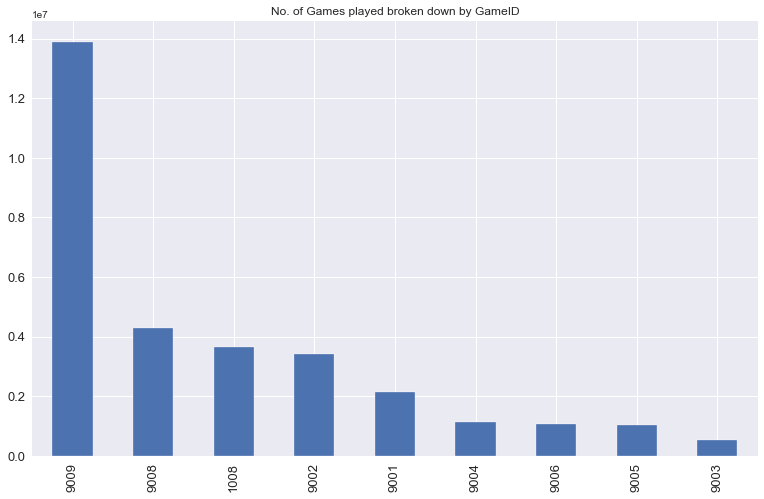

In [20]:
# Visualize the popularity of each GameID
fig=play_log_df[gameid].sum().sort_values(ascending=False).plot(kind='bar', figsize=(13,8), fontsize=13, title='No. of Games played broken down by GameID').get_figure()
fig.savefig('No. of Games played broken down by GameID.png', dpi=400)

### Popularity of betting level

100 chips per match seems to be the go-to playground while 1000 is the second most popular betting level. In general, the bigger table generate less matches. 

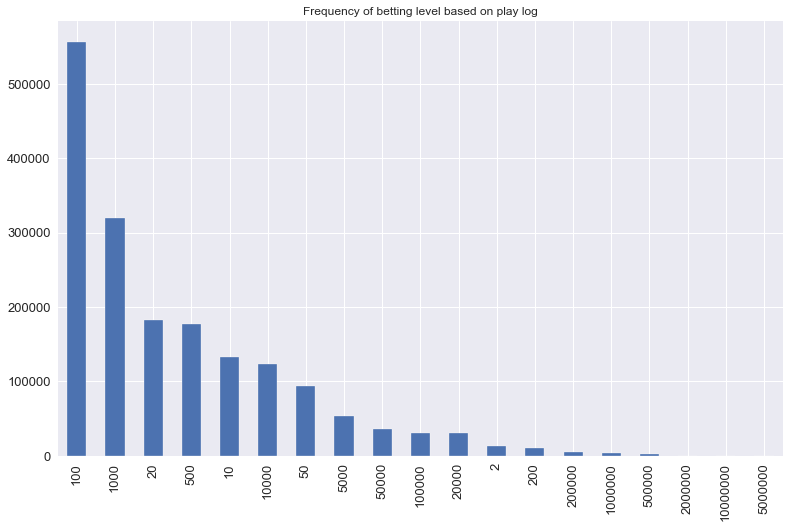

In [21]:
# Visualize the betting level based on each log
fig=play_log_df['Level'].value_counts().plot(kind='bar', figsize=(13,8), fontsize=13, title='Frequency of betting level based on play log').get_figure()
fig.savefig('Betting Level Popularity.png', dpi=400)

### Create other features from play log dataframe

I will create new features from the existing data frame namely the number of matches for each GameID and betting level that each unique user play. 

In [22]:
# Get a list of columns to aggregate later
features_list=list(play_log_df.columns)
columns_not_aggregated=['UserID', 'GameID', 'Level','Match_Length', 'Date', 'Day']

for e in columns_not_aggregated:
    features_list.remove(e)

In [23]:
# Aggregates the attributes of unique users 
player_details=play_log_df.groupby(['UserID']).sum()[features_list].reset_index()
player_details.head()

,UserID,WinNo,LostNo,WinAmt,LostAmt,Games_Played,Active_Time,9009,9005,9001,...,200000,10,20000,500000,50,2,200,10000000,5000000,2000000
0,123,0,1,0,5700,1,75,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1406,0,2,0,7000,2,150,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1980,0,3,0,417197,3,60,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3286,7,12,2998314,2048800,19,1425,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3452,15,36,13159123,18979771,51,2725,0,0,2,...,0,0,0,0,0,0,0,0,0,0


### Merge with total spending for each player

In [24]:
# Slice transactions that corresponds with the play log
transactions_df_01_13_05_2020=transactions_df.loc[(transactions_df['Date']>='2020-05-01') & (transactions_df['Date']<='2020-05-13')]

# Sum in-game purchase by users during t0 -> t4
transactions_df_01_13_05_2020=pd.DataFrame(transactions_df_01_13_05_2020.groupby(['UserID']).sum()['Amount'])
transactions_df_01_13_05_2020.reset_index(level='UserID')
transactions_df_01_13_05_2020

# Merge transactions records with play log and fill in 0 for users that did not make any purchase in the period
player_details=player_details.merge(transactions_df_01_13_05_2020, on='UserID', how='left')
player_details=player_details.fillna(0)

# Create Winning Rate and Losing Rate for all unique users
player_details['WinningRate']=player_details['WinNo']/player_details['Games_Played']
player_details['LosingRate']=player_details['LostNo']/player_details['Games_Played']


In [25]:
# Average Revenue Per Paying User for the period and estimation of the month
ARPU12=player_details['Amount'].sum()/len(player_details)
ARPU30=ARPU12/12*30
ARPU30

0.609197995143

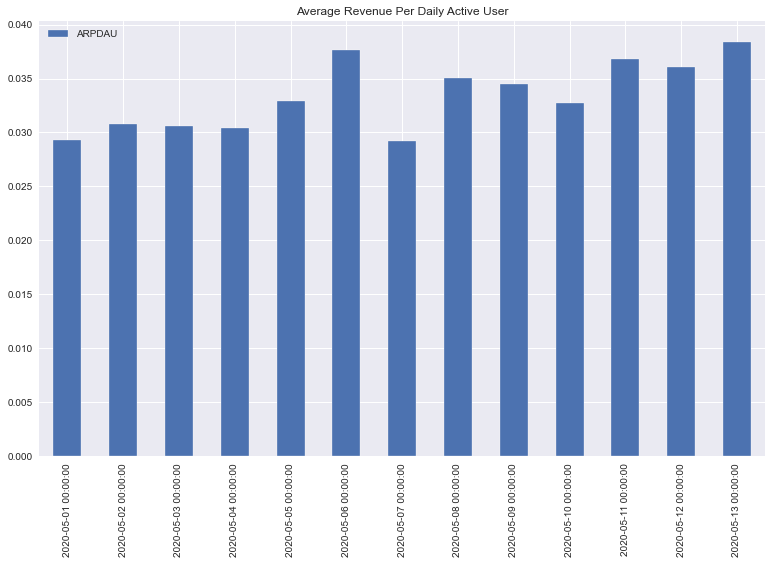

In [26]:
# Average Revenue Per Daily Active User
t0=play_log_df['Date'].min()
t_value=[]
ARPDAU_list=[]

# Get the date
for i in range(0,13):
    t_value.append(t0+datetime.timedelta(days=i))

# Make a list of ARPDAU
for t in t_value:
    ARPDAU=transactions_df.loc[(transactions_df['Date']==t)].sum()['Amount']/len(play_log_df.loc[(play_log_df['Date']==t)])
    ARPDAU_list.append(ARPDAU)

# Create a dataframe for ARPDAU from 2020-05-01 to 2020-05-13
ARPDAU_df=pd.DataFrame(ARPDAU_list, index=t_value, columns=['ARPDAU'])
fig=ARPDAU_df.plot(kind='bar', figsize=(13,8), title='Average Revenue Per Daily Active User').get_figure()
fig.savefig('ARPDAU.png', dpi=400)

According to Appannie, Virtual Currency Poker and Casino Games has a benchmark ARPU: USD 0.25 - USD 1.25. Given that Lengbear operates only in Cambodia, a country of GDP on the lower end, an ARPU30 can be estimated at around $0.60 which can be considered a highly performing game. 

In [27]:
# Number of paying user
Percent_Paying_User=(np.sum(player_details['Amount']>0))/len(player_details)
Percent_Paying_User

0.07396788753604482

Conversion rate is at around 7.4% which is also considered high by mobile gaming in social casino genre. 

In [28]:
top_paying_user=player_details.sort_values(by='Amount', ascending=False).head(10)
top_paying_user

,UserID,WinNo,LostNo,WinAmt,LostAmt,Games_Played,Active_Time,9009,9005,9001,...,500000,50,2,200,10000000,5000000,2000000,Amount,WinningRate,LosingRate
3534,1455403,1273,1483,17241461327,20446823182,2756,227370,1497,1,0,...,11,0,0,0,1,1,3,3232.0,0.461901,0.538099
9550,2484034,891,1200,7260573361,9420543000,2091,250920,2091,0,0,...,6,0,0,0,0,0,0,1150.0,0.426112,0.573888
126,812923,42,58,1557567236,2377740853,100,7500,0,0,0,...,1,0,0,0,0,2,1,378.0,0.420000,0.580000
636,888395,2991,3475,1787991727,2165565027,6466,503580,414,0,0,...,4,0,0,0,0,0,0,309.0,0.462573,0.537427
72462,5756306,268,588,2105186543,2690577375,856,102720,856,0,0,...,5,0,0,0,0,0,0,260.0,0.313084,0.686916
39987,5059628,41,76,285926770,607681770,117,10980,49,0,0,...,5,0,0,0,0,1,0,247.0,0.350427,0.649573
10092,2561168,590,1322,1339371177,1788458818,1912,182575,1280,26,0,...,0,0,0,0,0,0,0,231.0,0.308577,0.691423
40106,5065165,3472,14287,2711394399,3052283591,17759,479595,1171,0,0,...,9,0,0,0,0,0,1,223.0,0.195507,0.804493
55739,5494919,1272,1884,2751406904,3201019490,3156,315050,1757,7,355,...,23,0,0,0,0,0,3,220.5,0.403042,0.596958
52197,5419762,1551,2794,1886796976,2132829904,4345,488910,3634,0,474,...,4,0,0,0,0,0,0,219.0,0.356962,0.643038


# Prepare Data for modelling

In [29]:
# Getting t0 and list of days on which user data can be extracted
t0=play_log_df['Date'].min()
t_value=[]

for i in range(0,9):
    t_value.append(t0+datetime.timedelta(days=i))
    
print(f'The data set can have t0 can start from: {t_value[0]}, to: {t_value[-1]}, pass t_value[number] to function get_data to get the desired player data')

The data set can have t0 can start from: 2020-05-01 00:00:00, to: 2020-05-09 00:00:00, pass t_value[number] to function get_data to get the desired player data


## Create a function to get data from play log

In [30]:
def get_data(t0):

    ''' Generate player data from a given play log 
    
    Parameters
    ----------
    t0: A numeric input from range of play log
    
    Returns
    -------
    ret: a data frame of all user generated data including active session, winning rate, number of matches he/she plays, the amount of money user spent
    
    Examples
    --------
    >>>> t0=t_value[0] or t0='2020-05-01'
    >>>> get_data(t_value[0]) or get_data('YYYY-MM-DD')
    >>>> return play log dataframe
    
    '''

    # Pass in t0, t4 and tchurn
    t0=t0
    t0_t4_list=[]
    for i in range(0,4):
        t0_t4_list.append(t0+datetime.timedelta(days=i))    
    
    tchurn=t0+datetime.timedelta(days=4)
    print(f't0={t0} \ntchurn={tchurn}')
    
    # Get unique users on t0
    play_log_t0=play_log_df.loc[play_log_df['Date']==t0]
    t0_users=pd.DataFrame(play_log_t0['UserID'].unique(), columns=['UserID'])
    
    for t in t0_t4_list:
        
        play_log=play_log_df.loc[(play_log_df['Date']==t)]
        play_log=play_log.groupby(['UserID']).sum()[features_list].reset_index()
        play_log['WinningRate']=play_log['WinNo']/play_log['Games_Played']
        play_log['LosingRate']=play_log['LostNo']/play_log['Games_Played']
        
        transactions_log=transactions_df.loc[(transactions_df['Date']==t)]
        transactions_log=transactions_log.groupby(['UserID']).sum()['Amount'].reset_index()
        
        # Merge with unique users ID on t0
       
        t0_users=t0_users.merge(play_log, on='UserID', how='left').merge(transactions_log, on='UserID', how='left')
        t0_users=t0_users.fillna(0)
    
    # Slice out tchurn
    play_log_tchurn=play_log_df.loc[play_log_df['Date']==tchurn]

    # Getting target 
    final_play_log=t0_users.assign(Churn=t0_users.UserID.isin(play_log_tchurn.UserID).astype(int))

    return final_play_log

## Get the train data set

Passing the date t0 to get the train data set from t0 to t4

In [31]:
# Get the train data set
play_log_train=get_data(t_value[0])
play_log_train

t0=2020-05-01 00:00:00 
tchurn=2020-05-05 00:00:00


,UserID,WinNo_x,LostNo_x,WinAmt_x,LostAmt_x,Games_Played_x,Active_Time_x,9009_x,9005_x,9001_x,...,50_y,2_y,200_y,10000000_y,5000000_y,2000000_y,WinningRate_y,LosingRate_y,Amount_y,Churn
0,4775802,72,137,916575,1526575,209,20300,104,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.307692,0.692308,0.0,1
1,5929933,1,2,247,140,3,360,3,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.401869,0.598131,0.0,1
2,5728479,13,14,5558,7958,27,3150,25,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.538462,0.461538,0.0,1
3,5725542,0,3,0,20000,3,360,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.411960,0.588040,0.0,0
4,5942114,54,75,634997,626700,129,15210,123,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56158,5155914,2,12,659,701,14,1050,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
56159,5930800,1,2,2,556,3,225,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
56160,4858147,0,2,0,0,2,150,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0
56161,5345776,2,4,1693000,1315000,6,450,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1


In [32]:
# Assigning X_train and y_train
X_train=play_log_train.iloc[:,:-1]
X_train=X_train.drop(['UserID'], axis=1)

# Fill na for some value of 
X_train=X_train.fillna(0) 
X_train.shape

(56163, 148)

In [33]:
y_train=play_log_train.iloc[:,-1]
y_train.value_counts()

0    32014
1    24149
Name: Churn, dtype: int64

## Get the test data set

Call the function get_dat with t > t-churn to get the completely new data for test set

In [35]:
# Get a new set of users as the test set 
play_log_test=get_data(t_value[6])
play_log_test

t0=2020-05-07 00:00:00 
tchurn=2020-05-11 00:00:00


,UserID,WinNo_x,LostNo_x,WinAmt_x,LostAmt_x,Games_Played_x,Active_Time_x,9009_x,9005_x,9001_x,...,50_y,2_y,200_y,10000000_y,5000000_y,2000000_y,WinningRate_y,LosingRate_y,Amount_y,Churn
0,5867057,0,6,0,2360,6,720,6,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
1,6025400,0,4,0,5200,4,480,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
2,5480199,2,2,34780,5000,4,480,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
3,5984362,18,16,3438745,4616905,34,3045,11,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
4,2540633,3,1,5593,2100,4,480,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53829,4447334,2,4,10040,19900,6,450,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
53830,6027224,1,2,84,1308,3,225,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
53831,5833230,0,3,0,18000,3,360,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1
53832,5921946,3,2,130800,110000,5,600,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0


In [36]:
# Assigning X_test and y_test
X_test=play_log_test.iloc[:,:-1]
X_test=X_test.drop(['UserID'], axis=1)

# Fill na for some value of 
X_test=X_test.fillna(0) 

In [37]:
y_test=play_log_test.iloc[:,-1]
y_test.value_counts()

0    28416
1    25418
Name: Churn, dtype: int64

# Modelling

I will run the data through three models namely: Logistic Regression Model, Random Forrest and Multi-layer Perception Classifier

## Logistic Regression Model

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Instantiate model
churn_logistic_regression=LogisticRegression(random_state=42, max_iter=10000)

# 2. Fit model
churn_logistic_regression.fit(X_train, y_train)

# 3. Score model
print(f'Score on train: {churn_logistic_regression.score(X_train, y_train)}')
print(f'Score on test: {churn_logistic_regression.score(X_test, y_test)}')

# Getting the predicted value of y
y_pred = churn_logistic_regression.predict(X_test)

# Print out the report on accuracy
report_initial = classification_report(y_test, y_pred)
print(report_initial)

Score on train: 0.7585421006712605
Score on test: 0.7535758071107479
              precision    recall  f1-score   support

           0       0.80      0.70      0.75     28416
           1       0.71      0.81      0.76     25418

    accuracy                           0.75     53834
   macro avg       0.76      0.76      0.75     53834
weighted avg       0.76      0.75      0.75     53834



In [41]:
scores = churn_logistic_regression.predict_proba(X_test)

# Put in a dataframe
score_df = pd.DataFrame(scores, columns={'stay', 'churn'})
# score_df.insert(0, 'sms', sms_df['sms'])

score_df.nlargest(1000, ['churn'])

,stay,churn
11482,1.143530e-13,1.000000
9016,1.016298e-12,1.000000
51239,8.909540e-12,1.000000
1412,4.137446e-11,1.000000
654,9.529955e-11,1.000000
...,...,...
10080,1.074581e-02,0.989254
34140,1.074863e-02,0.989251
1505,1.076018e-02,0.989240
25305,1.078923e-02,0.989211


## Random Forrest

I will pass the data through  a range of number of tree from 1 - 100 with max depth of 3 to check which one would give the highest accuracy score on test data set. 

In [42]:
from sklearn.ensemble import RandomForestClassifier

estimator_number=list(range(1, 100))
train_scores=[]
test_scores=[]


for number in estimator_number:
    RF=RandomForestClassifier(n_estimators=number, 
                                      max_depth=3,
                                      random_state=42)
    RF.fit(X_train, y_train)

    train_scores.append(RF.score(X_train, y_train))
    test_scores.append(RF.score(X_test, y_test))
    
    print(f'finished {number} estimators', end='\r')

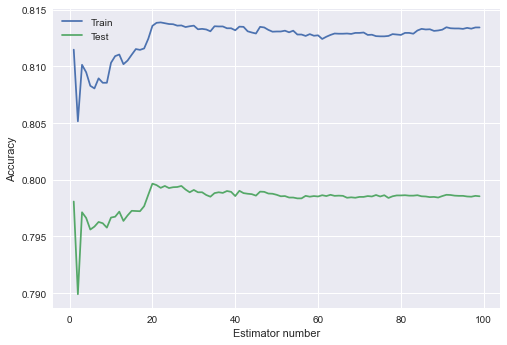

In [43]:
plt.figure()
plt.plot(estimator_number, train_scores, label="Train")
plt.plot(estimator_number, test_scores, label="Test")
plt.xlabel("Estimator number")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

It seems that the accuracy for both trainning and testing set hits maximum at around 20.

In [44]:
RF=RandomForestClassifier(n_estimators=20, 
                                      max_depth=3,
                                      random_state=42)
RF.fit(X_train, y_train)

print(f' Accuracy on train data: {RF.score(X_train, y_train)}')
print(f' Accuracy on test data: {RF.score(X_test, y_test)}')

 Accuracy on train data: 0.813578334490679
 Accuracy on test data: 0.7996619236913475


In [47]:
scores_RF = RF.predict_proba(X_test)

# Put in a dataframe
score_RF = pd.DataFrame(scores, columns={'stay', 'churn'})
# score_df.insert(0, 'sms', sms_df['sms'])

score_RF.nlargest(1000, ['churn'])

,stay,churn
11482,1.143530e-13,1.000000
9016,1.016298e-12,1.000000
51239,8.909540e-12,1.000000
1412,4.137446e-11,1.000000
654,9.529955e-11,1.000000
...,...,...
10080,1.074581e-02,0.989254
34140,1.074863e-02,0.989251
1505,1.076018e-02,0.989240
25305,1.078923e-02,0.989211


## Multi-layer Perceptron classifier

In [48]:
from sklearn.neural_network import MLPClassifier

In [49]:
my_skl_model = MLPClassifier(hidden_layer_sizes=(10), 
                             activation='relu',
                             max_iter=2000,
                             solver = 'adam')

In [50]:
# Fit the model
my_skl_model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [51]:
# Score the model
print(my_skl_model.score(X_train, y_train))
print(my_skl_model.score(X_test, y_test))

0.5700550184285027
0.5278262807890924


In [52]:
# Getting the predicted value of y
y_pred=my_skl_model.predict(X_test)

# Print out the report on accuracy
report_initial=classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.53      1.00      0.69     28416
           1       0.00      0.00      0.00     25418

    accuracy                           0.53     53834
   macro avg       0.26      0.50      0.35     53834
weighted avg       0.28      0.53      0.36     53834



# Conclusion

After running the models, we can get the list of users who are highly likely to churn we can approach these users in a few way to improve the chance of them staying in the game.
We can deploy A/B testing. We can offer promotion packages to people that are in the bracket of 80% and above. Furthermore, it might not be as profitable to offer promotions to people just on the border between staying or churning. You won't know unit after you run some A/B tests.